# Problem Session 7
## Forecasting The Bachelorette and Pumpkin Spice II

In the second of two time series based problem sessions you build upon your work in `Problem Session 6`. In particular you will look to build the best forecast you can for the Bachelorette IMDB ratings. Afterwards you will practice using a SARIMA model with the pumpkin spice Google trends data.

The problems in this notebook will cover the content covered in our `Time Series Forecasting` lectures including:
- `Averaging and Smoothing`,
- `Stationarity and Autocorrelation` and
- `SARIMA`.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from seaborn import set_style
from datetime import datetime

set_style("whitegrid")

#### 1. The Bachelorette

##### a.
Here we:

- Reload the Bachelorette IMDB data stored in `the_bachelorette.csv` in the `data` folder. 
- Look at the first five rows.
- Make a train test split setting aside the last three episodes as a test set.
- Visualize the training set.

In [2]:
tv = pd.read_csv(filepath_or_buffer="../../data/the_bachelorette.csv")
tv.head()

,episode_number,title,season,season_episode_number,imdb_rating
0,1,Episode #1.1,1,1,6.201235
1,2,Episode #1.2,1,2,6.201235
2,3,Episode #1.3,1,3,5.301235
3,4,Episode #1.4,1,4,5.801235
4,5,Episode #1.5,1,5,5.801235


In [3]:
tv_train = tv.iloc[:-3].copy()
tv_test = tv.drop(tv_train.index).copy()

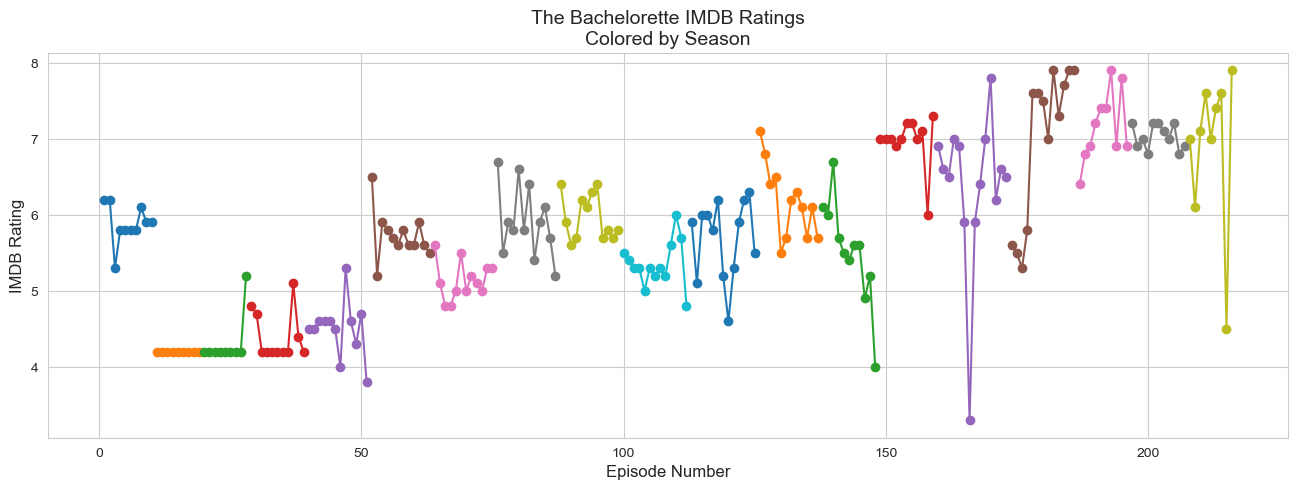

In [4]:
plt.figure(figsize=(16,5))

for season in range(1, tv_train.season.max()+1):
    plt.plot(tv_train.loc[tv_train.season==season].episode_number,
                tv_train.loc[tv_train.season==season].imdb_rating,
                '-o')

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.xlabel("Episode Number", fontsize=12)
plt.ylabel("IMDB Rating", fontsize=12)

plt.title("The Bachelorette IMDB Ratings\nColored by Season", fontsize=14)
    
plt.show()

Some notes on the dataset

* These are *subjective* assessments of episode quality which are made by self-selected raters.  This is far from a random sample.
* A lot of the variability will be due to things which are difficult to predict, such as popularity of particular contestants.

For these reasons we cannot expect to generate a forecast with much predictive ability.  We shouldn't really *expect* to be able to beat simple baselines like the naive baseline, rolling average, or random walk with drift.  The use of more "advanced" models is probably ill advised.  We are implementing more advanced models here to practice using them, not because it would be a good idea to actually trust these models.

##### b.

Here is a refresher on the columns of this data.

- `episode_number` is the number of the episode with respect to the entire series run,
- `title` is the title of the episode,
- `season` is the number of the season in which the episode aired,
- `season_episode_number` is the number of the episode with respect to the season in which it aired,
- `imdb_rating` is the average rating of the episode among IMDB's users.

##### c.

The first model you will fit is a rolling average model. In this problem you will be tuning the moving average window size, $q$, to find the value that minimizes the Mean Absolute Scaled Error (defined below).

Fill in the missing chunks of code to perform hyperparameter tuning for $q$.

In [5]:
# This function takes 3 numpy arrays as inputs.
# It returns the 
# mean absolute error of the forecast on the test set 
# relative to the
# mean absolute error of the naive forecast on the training set over an equivalent horizon.
# 
# If MASE > 1 then your forecast performs worse out of sample than naive forecast does in sample.
# If MASE < 1 then your forecast performs better out of sample than naive forecast does in sample.

def mase(y_train, y_test, y_preds):
    n = len(y_train)
    m = len(y_test)
    denom = 0
    for i in range(n-m):
        denom += np.abs(y_train[i+1:i+m+1] - y_train[i]*np.ones(m)).mean()
    denom = denom / (n-m)
    num = np.abs(y_test - y_preds).mean()
    return num/denom

# Example calculation

print('MASE = ', mase(y_train = np.array([1,2,3,4,5]), y_test = np.array([6,7]), y_preds = np.array([3, 3])))


MASE =  2.3333333333333335


This would be computed by hand as follows:

$$
\frac{\textrm{Mean absolute prediction error out of sample}}{\textrm{Mean absolute naive forecast prediction error in sample}} = \frac{\frac{1}{2} \left( |6-3| + |7-3|\right)}{\frac{1}{3} \left[ \frac{1}{2}\left(|2-1| + |3-1| \right) + \frac{1}{2}\left(|3-2| + |4-2| \right) + \frac{1}{2}\left(|4-3| + |5-3| \right)  \right]} = 2.333
$$


##### Sample Solution

In [6]:
from sklearn.model_selection import TimeSeriesSplit

In [7]:
cv = TimeSeriesSplit(10, test_size=3)

start = 2
end = 31
ra_mase = np.zeros((10, len(range(start, end))))


i = 0
for train_index, test_index in cv.split(tv_train):
    tv_tt = tv_train.iloc[train_index]
    tv_ho = tv_train.iloc[test_index]
    
    j = 0
    for q in range(start, end):
        pred = tv_tt.imdb_rating[-q:].mean() * np.ones(len(tv_ho))
        
        ra_mase[i,j] = mase(tv_tt.imdb_rating.values, tv_ho.imdb_rating.values, pred)
        j = j + 1
    i = i + 1

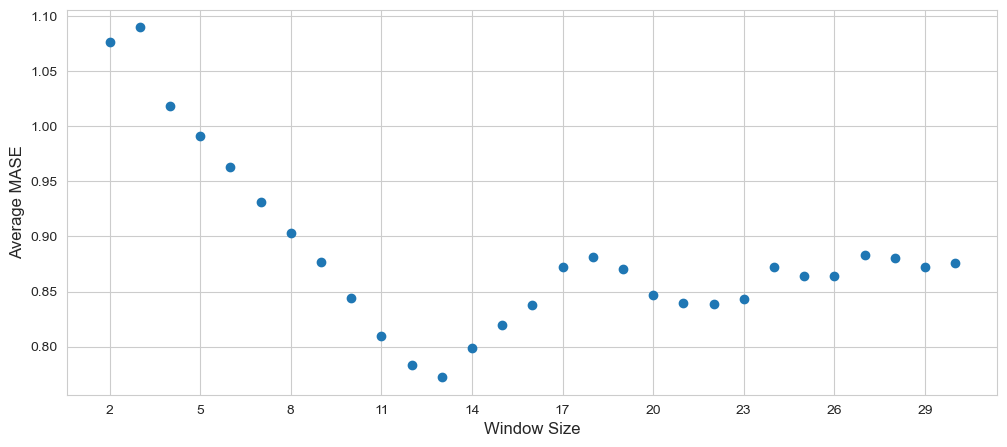

In [8]:
plt.figure(figsize=(12,5))

plt.scatter(range(start,end), np.mean(ra_mase, axis=0))

plt.xlabel("Window Size", fontsize=12)
plt.ylabel("Average MASE", fontsize=12)

plt.xticks(range(start, end, 3), fontsize=10)
plt.yticks(fontsize=10)

plt.show()

In [9]:
print("The window size that minimized the avg. cv MASE",
      "was q =", 
      range(start,end)[np.argmin(np.mean(ra_mase, axis=0))],
      "\b.",
      "It had a mean cv MASE of", 
      np.round(np.min(np.mean(ra_mase, axis=0)), 3))

The window size that minimized the avg. cv MASE was q = 13. It had a mean cv MASE of 0.772


##### d.

The second model you will try is an exponential smoothing model.

Because these data exhibit a trend but not seasonality we will fit a double exponential smoothing model. For this we will want to find the best $\alpha$ (The smoothing on the time series) and $\beta$ (the smoothing on the trend component).

Fill in the missing code chunks below to perform a grid search for the values of $\alpha$ and $\beta$ that minimize the average CV RMSE. (Note that a grid search is what we call it when you perform hyperparameter tuning with a grid of possible hyperparameter values).

##### Sample Solution

In [10]:
from statsmodels.tsa.holtwinters import Holt

In [11]:
exp_mase = np.zeros((10, len(np.arange(0, 0.2, .01)), len(np.arange(0, 0.2, .01))))

i = 0
for train_index, test_index in cv.split(tv_train):
    tv_tt = tv_train.iloc[train_index]
    tv_ho = tv_train.iloc[test_index]
    
    j = 0
    for alpha in np.arange(0, 0.2, .01):
        k = 0
        for beta in np.arange(0, 0.2, .01):
            exp_smooth = Holt(tv_tt.imdb_rating.values).fit(smoothing_level=alpha, 
                                                                      smoothing_trend=beta,
                                                                      optimized=False)

            exp_mase[i,j,k] = mase(tv_tt.imdb_rating.values, tv_ho.imdb_rating.values, exp_smooth.forecast(len(tv_ho)))
            k = k + 1
        j = j + 1
    i = i + 1

In [12]:
## This gives us the indices of the smallest
## avg cv rmse
exp_ind = np.unravel_index(np.argmin(np.mean(exp_mase, axis=0), axis=None), 
                           np.mean(exp_mase, axis=0).shape)
np.unravel_index(np.argmin(np.mean(exp_mase, axis=0), axis=None), 
                 np.mean(exp_mase, axis=0).shape)

(1, 14)

In [13]:
print("The alpha and beta values that give a double exponential",
         "smoothing model with lowest avg cv rmse are",
         "alpha = ", np.arange(0, 0.2, .01)[exp_ind[0]],
         "and beta = ", np.arange(0, 0.2, .01)[exp_ind[1]])

print("This model had an avg cv rmse of",
         np.round(np.mean(exp_mase, axis=0)[exp_ind],3))

The alpha and beta values that give a double exponential smoothing model with lowest avg cv rmse are alpha =  0.01 and beta =  0.14
This model had an avg cv rmse of 0.773


##### e.

The final model you will try is an ARIMA model. 

First let's check the stationarity assumption for this time series. Make an autocorrelation plot of the training data. If you find that the ACF plot indicates that the time series is non-stationary, plot the ACF of the time series' first differences. Do these appear to be stationary?

##### Sample Solution

In [14]:
import statsmodels.api as sm

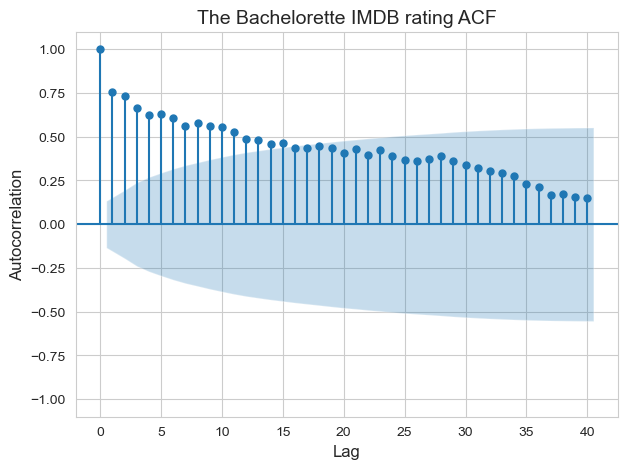

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(7,5))

sm.graphics.tsa.plot_acf(tv_train.imdb_rating.values,
                            lags = 40,
                            ax = ax)

plt.title('The Bachelorette IMDB rating ACF', fontsize=14)
plt.ylabel("Autocorrelation", fontsize=12)
plt.xlabel("Lag", fontsize=12)

plt.ylim(-1.1,1.1)

plt.show()

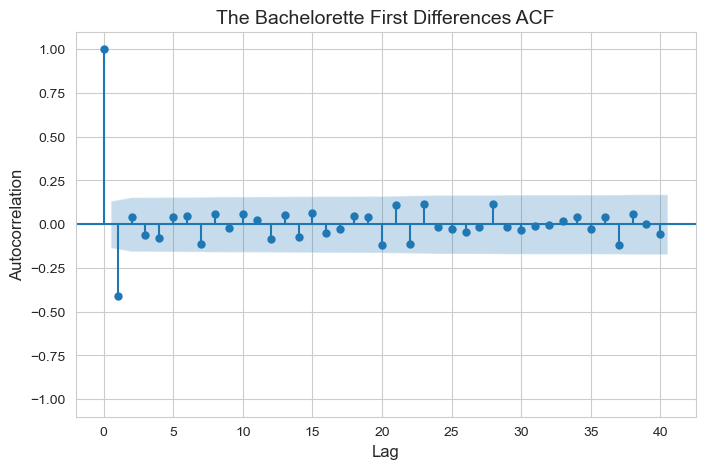

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(8,5))

sm.graphics.tsa.plot_acf(tv_train.imdb_rating.diff().values[1:],
                               lags=40,
                               ax=ax)

plt.title('The Bachelorette First Differences ACF', fontsize=14)
plt.ylabel("Autocorrelation", fontsize=12)
plt.xlabel("Lag", fontsize=12)

plt.ylim(-1.1,1.1)

plt.show()

##### f.

From what we saw above what we should set our $d$ value in the ARIMA model?. Set $d$ to this value and then perform hyperparameter tuning to find the values of $p$ and $q$ that give us the lowest mean CV RMSE.

##### Sample Solution

In [17]:
from statsmodels.tsa.api import ARIMA

In [18]:
arima_mase = np.zeros((10, 4, 4))

i = 0
for train_index, test_index in cv.split(tv_train):

    tv_tt = tv_train.iloc[train_index]
    tv_ho = tv_train.iloc[test_index]
    
    j = 0
    for p in range(4):
        k = 0
        for q in range(4):
            arima = ARIMA(tv_tt.imdb_rating.values,
                               order=(p, 1, q)).fit()
            
            arima_mase[i,j,k] = mase(tv_tt.imdb_rating.values, tv_ho.imdb_rating.values,  arima.forecast(len(tv_ho)))
            k = k +1
        j = j + 1
    i = i +1

/opt/homebrew/Caskroom/miniforge/base/envs/erdos_sp_2024_new/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/homebrew/Caskroom/miniforge/base/envs/erdos_sp_2024_new/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/homebrew/Caskroom/miniforge/base/envs/erdos_sp_2024_new/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/Caskroom/miniforge/base/envs/erdos_sp_2024_new/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum 

In [19]:
arima_ind = np.unravel_index(np.argmin(np.mean(arima_mase, axis=0), axis=None), 
                             np.mean(arima_mase, axis=0).shape)
np.unravel_index(np.argmin(np.mean(arima_mase, axis=0), axis=None), 
                 np.mean(arima_mase, axis=0).shape)

(2, 2)

In [20]:
print("The parameters that give an ARIMA model",
         "with lowest avg cv mase are",
         "(p,d,q) = ( %s, %s, %s )" %(range(4)[arima_ind[0]], 1, range(4)[arima_ind[1]]))

print("This model had an avg cv mase of",
         np.round(np.mean(arima_mase, axis=0)[arima_ind],3))

The parameters that give an ARIMA model with lowest avg cv mase are (p,d,q) = ( 2, 1, 2 )
This model had an avg cv mase of 0.927


As an alternative to cross validation MASE, another common way to select ARIMA parameters is by minimizing the [Akaike Information Criterion (AIC)](https://en.wikipedia.org/wiki/Akaike_information_criterion) on the training set.  Let's see whether this yields the same hyperparameters as we obtained above.  There is a handy object called `auto_arima` from `pmdarima` which can do automatic order selection in this way.

In [21]:
from pmdarima import auto_arima

In [22]:
auto_arima(tv_train.imdb_rating.values, trace=True, max_p=4, max_q=4)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=416.036, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=476.560, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=434.059, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=421.034, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=474.586, Time=0.00 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=419.650, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=420.493, Time=0.03 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=418.563, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=420.328, Time=0.26 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=417.774, Time=0.04 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit time: 

ARIMA(order=(2, 1, 2), scoring_args={}, suppress_warnings=True)

We obtained the same parameters!

In [23]:
arima = ARIMA(tv_train.imdb_rating.values,order=(2, 1, 2)).fit()
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  216
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -203.887
Date:                Thu, 21 Mar 2024   AIC                            417.774
Time:                        12:17:37   BIC                            434.627
Sample:                             0   HQIC                           424.583
                                - 216                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2204      0.492      0.448      0.654      -0.744       1.185
ar.L2          0.2346      0.170      1.380      0.168      -0.099       0.568
ma.L1         -0.8143      0.499     -1.633      0.102      -1.792       0.163
ma.L2         -0.0776      0.410     -0.189      0.850      -0.882       0.726
sigma2         0.3887      0.023     16.744      0.000       0.343       0.434
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               254.72
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               2.90   Skew:                            -0.50
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

##### g.

Plot your forecast (along with the training and test data) using the model with the lowest CV MASE.

What is the MASE on the test set?

##### Sample Solution

In [24]:
rolling_avg_train_preds = tv_train.imdb_rating.rolling(13).mean()
rolling_avg_test_preds = rolling_avg_train_preds.iloc[-1] * np.ones(len(tv_test))

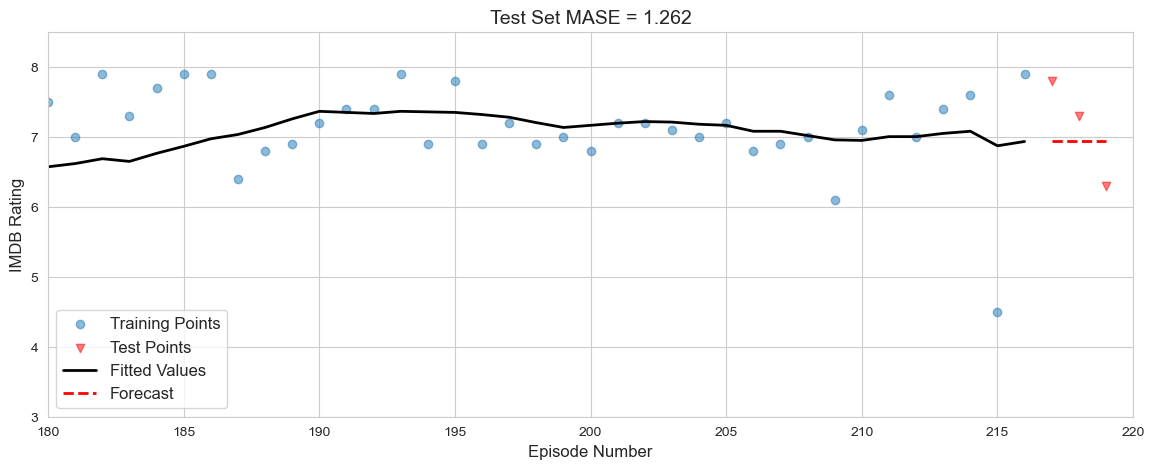

In [25]:
plt.figure(figsize=(14,5))

plt.scatter(tv_train.episode_number,
               tv_train.imdb_rating,
               alpha=.5,
               label="Training Points")

plt.scatter(tv_test.episode_number,
               tv_test.imdb_rating,
               alpha=.5,
               c = 'red',
               marker = 'v',
               label="Test Points")

plt.plot(tv_train.episode_number,
            rolling_avg_train_preds,
            'k-',
            linewidth = 2,
            label="Fitted Values")

plt.plot(tv_test.episode_number,
            rolling_avg_test_preds,
            'r--',
            linewidth=2,
            label="Forecast")

plt.legend(fontsize=12, loc=3)

test_mase = mase(y_train = tv_train.imdb_rating.values, y_test = tv_test.imdb_rating.values, y_preds = rolling_avg_test_preds)

plt.title("Test Set MASE = " + str(np.round(test_mase,3)),
             fontsize=14)

plt.xlabel("Episode Number", fontsize=12)
plt.ylabel("IMDB Rating", fontsize=12)


plt.ylim(3,8.5)
plt.xlim(180,220)

plt.show()

#### 2. Pumpkin spice SARIMA

We won't have enough time in this problem session to do more extensive model building and comparison for the Pumpkin Spice data forecasting problem.  We will just use this as opportunity to practice fitting SARIMA models.

Load the data stored in `pumpkin_spice.csv` in the `Data` folder then look at the first five rows. Then make a train test split setting aside all observations on or after January 1, 2022 aside as the test set.

##### Sample Solution

In [26]:
pumpkin = pd.read_csv("../../data/pumpkin_spice.csv",
                         parse_dates = ["Month"])

In [27]:
p_train = pumpkin.loc[pumpkin.Month < datetime(2022, 1, 1)].copy()
p_test = pumpkin.drop(p_train.index).copy()

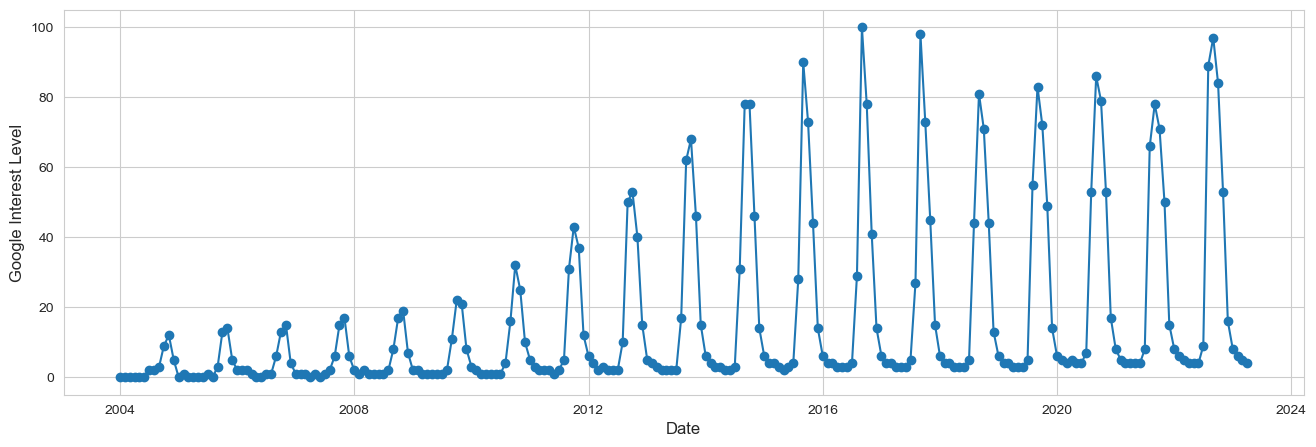

In [28]:
plt.figure(figsize=(16,5))

plt.plot(pumpkin.Month,
            pumpkin.interest_level,
            '-o')

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.xlabel("Date", fontsize=12)
plt.ylabel("Google Interest Level", fontsize=12)

plt.show()

##### b.

In lecture we talked about first differencing non-stationary time series exhibiting a trend to create a, seemingly, stationary time series.

This can also be done for seasonal data. Suppose that we suspect a time series, $\left\lbrace y_t \right\rbrace$ exhibits seasonality where a season lasts $m$ time steps. Then the first seasonal differenced time series is:

$$
\nabla_s y_t = y_t - y_{t-m}.
$$

Plot the autocorrelation of the training set, then perform first seasonal differencing on these data and plot the autocorrelation of the first seasonal differenced series.

Does the differenced series appear less likely to violate stationarity?

##### Sample Solution

In [29]:
import statsmodels.tsa.api as sm

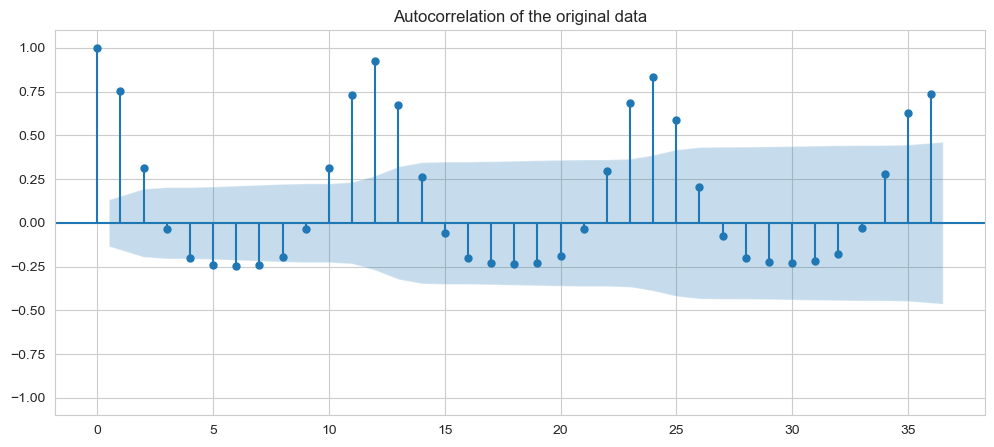

In [30]:
fig,ax = plt.subplots(1,1, figsize=(12,5))

sm.graphics.plot_acf(p_train.interest_level.values,
                        lags = 36,
                        ax = ax)

plt.title('Autocorrelation of the original data')

plt.ylim([-1.1,1.1])

plt.show()

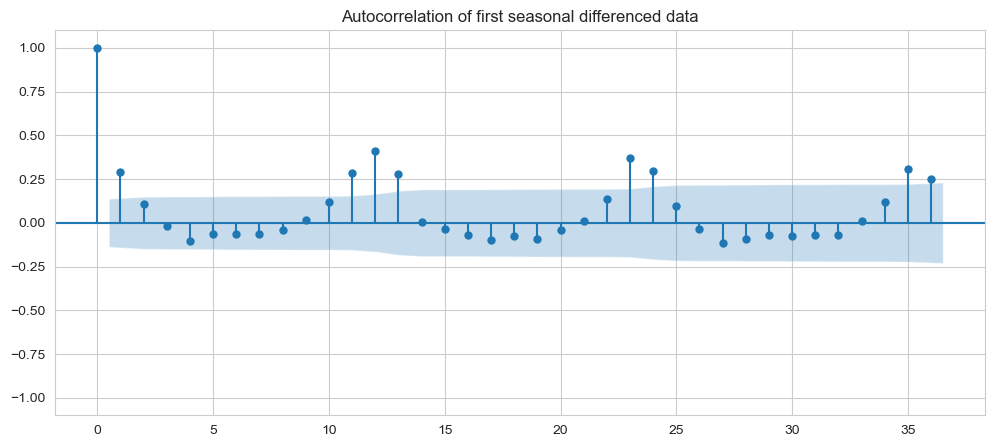

In [31]:
fig,ax = plt.subplots(1,1, figsize=(12,5))

sm.graphics.plot_acf(p_train.interest_level.diff(12).values[12:],
                        lags = 36,
                        ax = ax)

plt.title('Autocorrelation of first seasonal differenced data')
plt.ylim([-1.1,1.1])

plt.show()

##### c.

Recall for an $\text{ARIMA}$ model you needed parameters $p$, $d$ and $q$. For a $\text{SARIMA}$ model you need parameters $P$, $D$, $Q$ and $m$ as well:

- $P$ is the order of the seasonal autoregressive portion of the model,
- $Q$ is the order of the seasonal moving average portion of the model,
- $D$ is the order of the seasonal differencing and
- $m$ is the number of time steps that take place in a single period.

Use `auto_arima` with $D=1$ and $m=12$ and determine the AIC minimizing values of $p,d,q,P,Q$.

##### Sample Solution

In [32]:
auto_arima(p_train.interest_level.values, trace=True, seasonal=True, D = 1, m=12).summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=1120.744, Time=0.51 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1158.573, Time=0.00 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1118.556, Time=0.08 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1125.827, Time=0.09 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1178.837, Time=0.00 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1142.492, Time=0.02 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1118.156, Time=2.30 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1118.835, Time=0.93 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=1116.843, Time=0.10 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=1124.691, Time=0.09 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=1118.828, Time=0.74 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=1123.386, Time=1.19 sec
 ARIMA(1,0,0)(2,1,2)[12] intercept   : AIC=1120.457, Time=1.09 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=1118.218, Time=0.10 sec
 ARIMA(2,0,0)(1,1,1

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  216
Model:             SARIMAX(1, 0, 0)x(1, 1, [1], 12)   Log Likelihood                -553.421
Date:                              Thu, 21 Mar 2024   AIC                           1116.843
Time:                                      12:17:46   BIC                           1133.433
Sample:                                           0   HQIC                          1123.554
                                              - 216                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3500      0.296      1.184      0.237      -0.230       0.930
ar.L1          0.1359      0.046      2.942      0.003       0.045       0.227
ar.S.L12       0.6705      0.080      8.381      0.000       0.514       0.827
ma.S.L12      -0.3489      0.087     -4.013      0.000      -0.519      -0.178
sigma2        13.1487      0.713     18.452      0.000      11.752      14.545
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               766.10
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):              15.48   Skew:                            -0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [33]:
sarima = ARIMA(p_train.interest_level.values,
                    order = (1,0,0),
                    seasonal_order = (1,1,1,12)).fit()

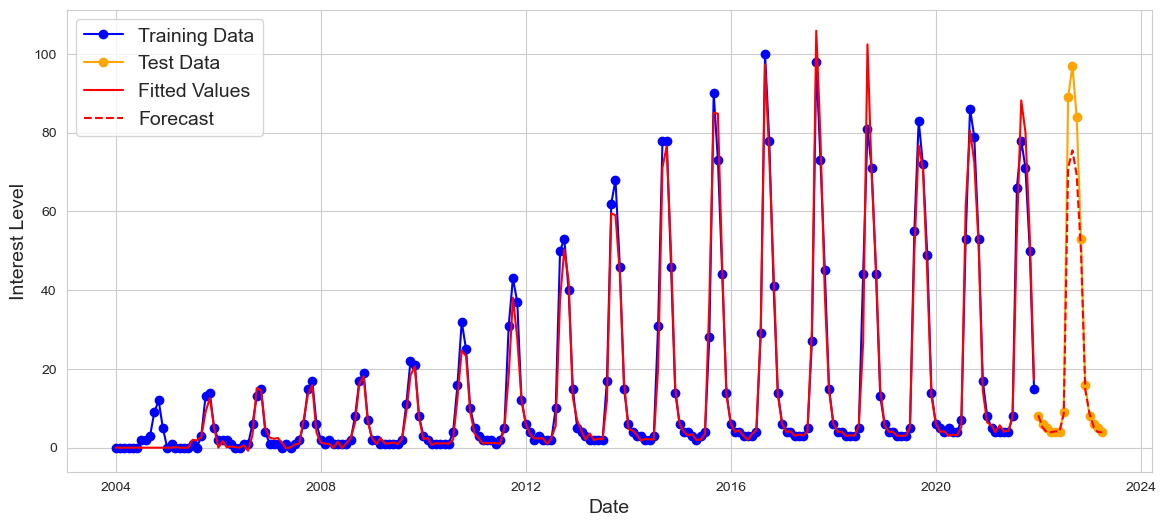

In [34]:
plt.figure(figsize=(14,6))

plt.plot(p_train.Month,
            p_train.interest_level,
            'b-o',
            label='Training Data')


plt.plot(p_test.Month,
            p_test.interest_level,
            color = 'orange',
            marker = 'o',
            label='Test Data')

plt.plot(p_train.Month,
            sarima.fittedvalues,
            'r',
            label='Fitted Values')

plt.plot(p_test.Month,
               sarima.forecast(len(p_test)),
               '--r',
               label="Forecast")


plt.legend(fontsize=14)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Interest Level", fontsize=14)

plt.show()

--------------------------

This notebook was written for the Erd&#337;s Institute C&#337;de Data Science Boot Camp by Matthew Osborne, Ph. D., 2023. Modified by Steven Gubkin 2024.

Any potential redistributors must seek and receive permission from Matthew Tyler Osborne, Ph.D. prior to redistribution. Redistribution of the material contained in this repository is conditional on acknowledgement of Matthew Tyler Osborne, Ph.D.'s original authorship and sponsorship of the Erdős Institute as subject to the license (see License.md)